## Imports

In [1]:
# can be used to install archtype analysis
import sys
!pip install py_pcha

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import numpy as np
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from pathlib import Path
import scipy.io
import py_pcha
import time

import warnings
warnings.filterwarnings('ignore')

## Load dataset

In [3]:
path = Path().cwd()

data_path = path.parent / "Matlab" / "Data" / "zipdata.mat"
mat = scipy.io.loadmat(data_path)

traindata = mat['traindata']

y=traindata[:,0].T+1
X=traindata[:,1:].T
X=X-np.min(X)

p, n = np.shape(X)

print(f'number of observations: {n}, number of features: {p}')

number of observations: 7291, number of features: 256


## NMF functions

In [4]:
def NMFLS(X,noc,maxiter=50,W=None,H=None):
    # Non-negative matrix factorization based on Multiplicative Updates
    #
    # Minimize 0.5*||X-WH||_F^2 s.t. W>=0, H>=0
    #
    # Input
    #   X       I x J data matrix
    #   noc     number of components
    #   maxiter maximum number of iterations
    #
    # Output
    #   W           I x noc non-negative matrix
    #   H           noc x J non-negative matrix
    #   L           Least square error of fit, i.e. 0.5*||X-XSH||_F^2
    #   cpu_time    pr. iteration cost

    I,J = X.shape

    if W is None:
        W=np.random.rand(I,noc)
    if H is None:
        H=np.random.rand(noc,J)
        
    L=np.zeros(maxiter)
    cpu_time=np.zeros(maxiter)
    SST=np.sum(X*X)
    HHt=H @ H.T
    
    tol=1e-9*np.sqrt(SST/(I*J))
    eps = np.finfo(np.float32).eps
    
    for iter_ in range(maxiter):
        start_time = time.time()      
        
        #Update W
        XHt=X @ H.T    
        for k in range(10): # Take 10 steps to save computations
            W=np.where(W>tol, W, tol) * XHt / (W @ HHt+eps)

        #Update H
        WtX=W.T @ X
        WtW=W.T @ W
        for k in range(10): # Take 10 steps to save computations
            H=np.where(H>tol, H, tol) * WtX / (WtW @ H+eps);

        #Evaluate objective function
        HHt=H @ H.T
        L[iter_]=0.5*(SST+np.sum(WtW*HHt)-2*np.sum(WtX*H))
        
        cpu_time[iter_]=time.time() - start_time
        
        print('iter {} objective value {:f} pct. explained variance {:f}'.format(iter_,L[iter_],(1-L[iter_]/(0.5*SST))*100))
        
    return W, H, L, cpu_time

In [5]:
def NMFKL(X,noc,maxiter=50,W=None,H=None):
    # Non-negative matrix factorization based on Multiplicative Updates
    #
    # Minimize \sum_{i,j} (WH)_ij log(x_(ij)/(WH)_ij)+x_ij-(WH)_ij  s.t. W>=0, H>=0
    #
    # Input
    #   X    I x J data matrix
    #   noc  number of components
    #
    # Output
    #   W    I x noc non-negative matrix
    #   H    noc x J non-negative matrix
    #   L    Least square error of fit, i.e. 0.5*||X-XSH||_F^2

    I,J = X.shape

    if W is None:
        W=np.random.rand(I,noc)
    if H is None:
        H=np.random.rand(noc,J)
        
    L=np.zeros(maxiter)
    L_LS=np.zeros(maxiter)
    SST=np.sum(X*X)
    R=W @ H
    
    tol=1e-9*np.sqrt(SST/(I*J))
    eps = np.finfo(np.float32).eps
    
    for iter_ in range(maxiter):

        # Update W (add eps to all the denominators to avoid dividing by zero)    
        W = np.where(W>tol, W, tol) * ((X /(R+eps)) @ H.T @ np.diag(1 / (np.sum(H,axis=1)+eps)))


        # Update H (add eps to all the denominators to avoid dividing by zero)
        R=W @ H
        H = np.where(H>tol, H, tol) * (np.diag(1 /(np.sum(W, axis=0)+eps)) @ W.T @ (X /(R+eps)))        

        # Evaluate objective function
        R=W @ H
        L[iter_]=np.sum(X*np.log((X+eps)/(R+eps)))-np.sum(X)+np.sum(R)
        L_LS[iter_]=0.5*np.sum((R-X)**2) # Calculate LS error for comparison to KL
        
        print('iter {} objective value {:f} pct. explained variance {:f}'.format(iter_,L[iter_],(1-L_LS[iter_]/(0.5*SST))*100))
    
    return W, H, L, L_LS

## Perform NMF

In [6]:
Ndigit=250 #Limit the number of observation we use for speed purposes
n_components=25

W_LS, H_LS, L_LS, _ = NMFLS(X[:,0:Ndigit],n_components,maxiter=250)
W_KL, H_KL, L_KL, L_LSKL = NMFKL(X[:,0:Ndigit],n_components,maxiter=250,W=W_LS,H=H_LS)

iter 0 objective value 12928.498029 pct. explained variance 55.055475
iter 1 objective value 7525.579559 pct. explained variance 73.838136
iter 2 objective value 6196.144725 pct. explained variance 78.459773
iter 3 objective value 5660.667605 pct. explained variance 80.321301
iter 4 objective value 5405.161105 pct. explained variance 81.209542
iter 5 objective value 5258.879059 pct. explained variance 81.718076
iter 6 objective value 5165.155440 pct. explained variance 82.043896
iter 7 objective value 5098.351001 pct. explained variance 82.276134
iter 8 objective value 5046.631605 pct. explained variance 82.455931
iter 9 objective value 5005.224000 pct. explained variance 82.599880
iter 10 objective value 4971.923462 pct. explained variance 82.715646
iter 11 objective value 4945.435873 pct. explained variance 82.807727
iter 12 objective value 4924.145539 pct. explained variance 82.881741
iter 13 objective value 4906.057010 pct. explained variance 82.944623
iter 14 objective value 4890.

iter 195 objective value 4542.051841 pct. explained variance 84.210048
iter 196 objective value 4541.767639 pct. explained variance 84.211036
iter 197 objective value 4541.479603 pct. explained variance 84.212037
iter 198 objective value 4541.178593 pct. explained variance 84.213084
iter 199 objective value 4540.857976 pct. explained variance 84.214198
iter 200 objective value 4540.514689 pct. explained variance 84.215392
iter 201 objective value 4540.148634 pct. explained variance 84.216664
iter 202 objective value 4539.773788 pct. explained variance 84.217967
iter 203 objective value 4539.401855 pct. explained variance 84.219260
iter 204 objective value 4539.023890 pct. explained variance 84.220574
iter 205 objective value 4538.625830 pct. explained variance 84.221958
iter 206 objective value 4538.216394 pct. explained variance 84.223381
iter 207 objective value 4537.820031 pct. explained variance 84.224759
iter 208 objective value 4537.444868 pct. explained variance 84.226064
iter 2

iter 69 objective value 7963.350766 pct. explained variance 82.442186
iter 70 objective value 7962.797966 pct. explained variance 82.440533
iter 71 objective value 7962.269601 pct. explained variance 82.438861
iter 72 objective value 7961.769510 pct. explained variance 82.437175
iter 73 objective value 7961.298688 pct. explained variance 82.435490
iter 74 objective value 7960.855740 pct. explained variance 82.433822
iter 75 objective value 7960.437714 pct. explained variance 82.432190
iter 76 objective value 7960.040926 pct. explained variance 82.430609
iter 77 objective value 7959.661539 pct. explained variance 82.429089
iter 78 objective value 7959.295858 pct. explained variance 82.427639
iter 79 objective value 7958.940490 pct. explained variance 82.426261
iter 80 objective value 7958.592430 pct. explained variance 82.424956
iter 81 objective value 7958.249132 pct. explained variance 82.423722
iter 82 objective value 7957.908567 pct. explained variance 82.422556
iter 83 objective va

iter 202 objective value 7927.647030 pct. explained variance 82.357161
iter 203 objective value 7927.494911 pct. explained variance 82.356982
iter 204 objective value 7927.338291 pct. explained variance 82.356820
iter 205 objective value 7927.177528 pct. explained variance 82.356676
iter 206 objective value 7927.013308 pct. explained variance 82.356550
iter 207 objective value 7926.846619 pct. explained variance 82.356438
iter 208 objective value 7926.678659 pct. explained variance 82.356337
iter 209 objective value 7926.510696 pct. explained variance 82.356242
iter 210 objective value 7926.343902 pct. explained variance 82.356149
iter 211 objective value 7926.179195 pct. explained variance 82.356050
iter 212 objective value 7926.017141 pct. explained variance 82.355942
iter 213 objective value 7925.857932 pct. explained variance 82.355820
iter 214 objective value 7925.701479 pct. explained variance 82.355681
iter 215 objective value 7925.547568 pct. explained variance 82.355524
iter 2

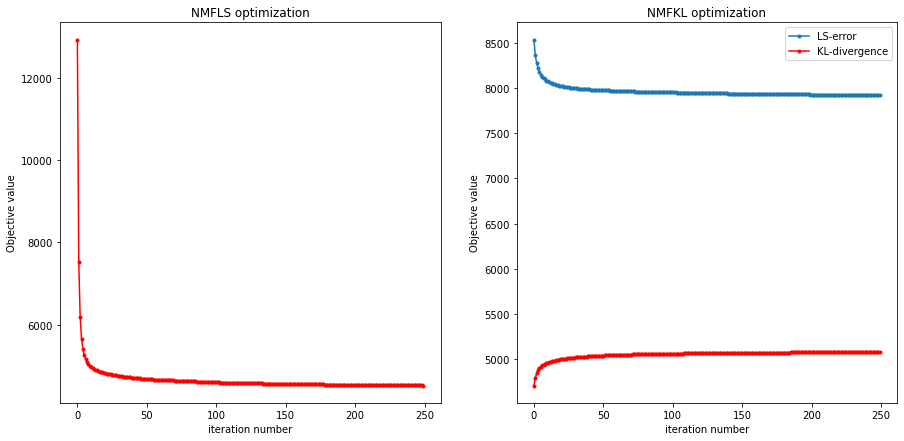

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

_ = ax[0].plot(L_LS,'.-r')
ax[0].set_title('NMFLS optimization')
ax[0].set_ylabel('Objective value')
ax[0].set_xlabel('iteration number')

#Display KL error and corresponding LS error
_ = ax[1].plot(L_KL,'.-')
_ = ax[1].plot(L_LSKL,'.-r') # Corresponding LS error for each iteration of NMFKL
ax[1].set_title('NMFKL optimization')
ax[1].set_ylabel('Objective value')
ax[1].set_xlabel('iteration number')
ax[1].legend({'KL-divergence','LS-error'})

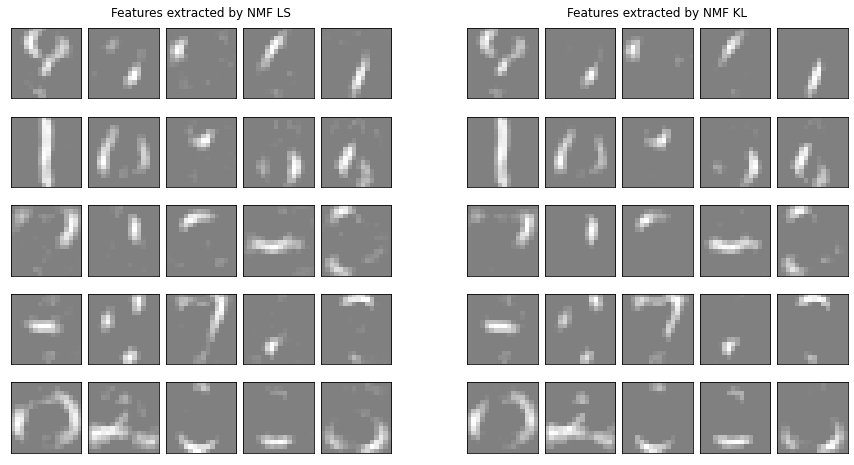

In [8]:
image_shape = (16, 16, n_components)
left = 0.0
right = 0.0
bottom = 0.99
top = 0.83
wspace = 0.0
hspace = 0.0
fig = plt.figure(figsize=(15, 8))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

# Display the extracted features of NMFLS
ax = plt.Subplot(fig, outer[0])
ax.set_title('Features extracted by NMF LS')
ax.axis('off')
fig.add_subplot(ax)
    
inner = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=outer[0], wspace=0.1, hspace=0.1)
comps = np.reshape(W_LS,image_shape)
for i in range(n_components):
    comp = comps[:,:,i]
    ax = plt.Subplot(fig, inner[i])
    # normalize colormap
    vmax = max(comp.max(), -comp.min())
    ax.imshow(comp, cmap=plt.cm.gray, interpolation='nearest', vmin=-vmax, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)

# Display the extracted features of NMFKL
ax = plt.Subplot(fig, outer[1])
ax.set_title('Features extracted by NMF KL')
ax.axis('off')
fig.add_subplot(ax)
    
inner = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=outer[1], wspace=0.1, hspace=0.1)
comps = np.reshape(W_KL,image_shape)
for i in range(n_components):
    comp = comps[:,:,i]
    ax = plt.Subplot(fig, inner[i])
    # normalize colormap
    vmax = max(comp.max(), -comp.min())
    ax.imshow(comp, cmap=plt.cm.gray, interpolation='nearest', vmin=-vmax, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.add_subplot(ax)